## Visualizing High-Dimensional MNIST Dataset Embeddings Using Principal Component Analysis (**PCA**) and T-Distributed Stochastic Neighbor Embedding (**t-SNE**)

#### In this practical work, we will use embeddings extracted from a CNN trained on the MNIST dataset. Our objective is to apply PCA and t-SNE separately, and then compare these techniques with the results of applying t-SNE on PCA-reduced embeddings.

###### Source: Adapted and inspired by Towards Data Science

#### Importing Packages

In [1]:
# Essential Imports
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import seaborn as sns

#### Loading **MNIST** Dataset

In [2]:
# Load and preprocess MNIST data

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data / 255.0
y = mnist.target
print(X.shape, y.shape)

(70000, 784) (70000,)


In [3]:
# Reshape X to (n_samples, height, width, 1) and encode y
height, width = 28, 28
X = X.values.reshape(-1, height, width, 1).astype('float32')
y = LabelEncoder().fit_transform(y)  # Convert labels to integers
y = to_categorical(y, num_classes=10)  # One-hot encode labels

In [4]:
# For reproducability of the results

np.random.seed(42)

# Generate a random permutation of indices
rndperm = np.random.permutation(X.shape[0])

# Shuffle X and y using the random permutation
X_shuffled = X[rndperm]
y_shuffled = y[rndperm]


#### Visualising couple of digits randomly

<Figure size 640x480 with 0 Axes>

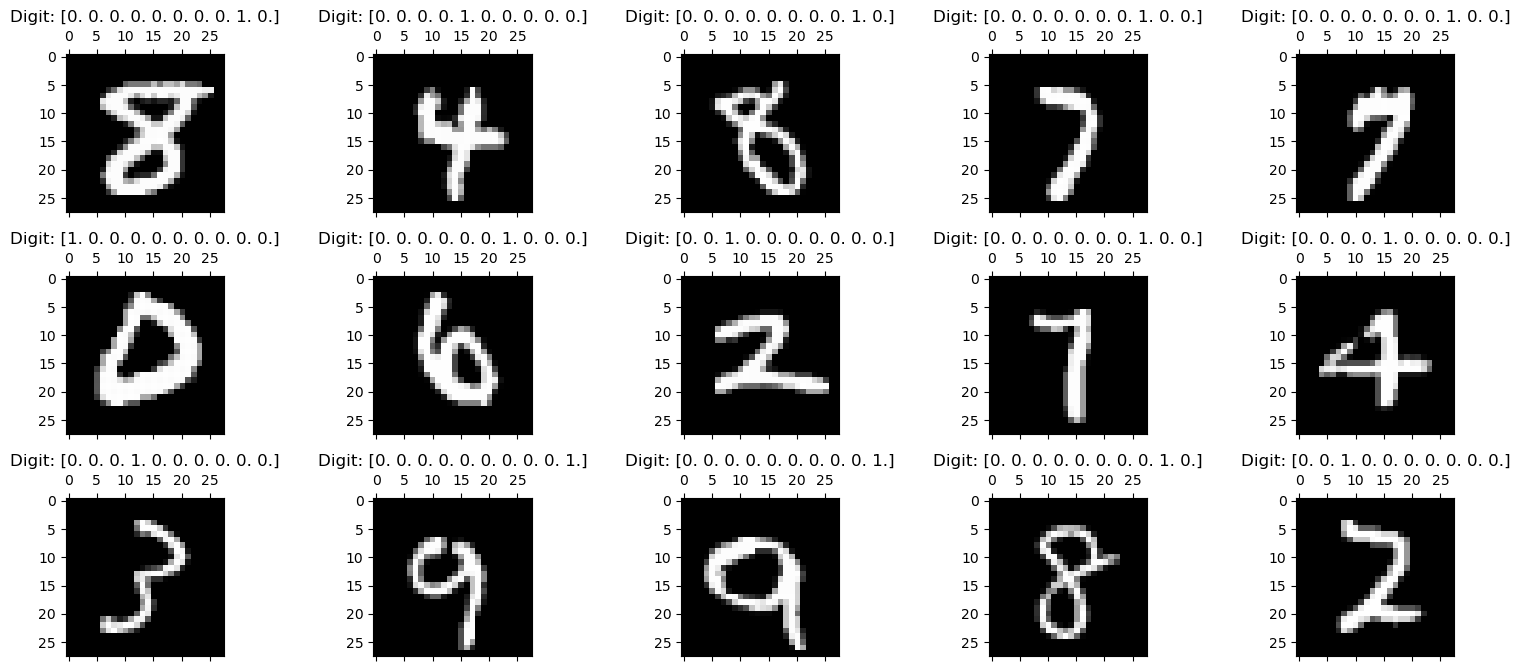

In [5]:
plt.gray()
fig = plt.figure(figsize=(16, 7))

# Display 15 random digits
for i in range(0, 15):
    random_index = rndperm[i]  # Use the precomputed random permutation
    ax = fig.add_subplot(3, 5, i + 1, title="Digit: {}".format(str(y[random_index])))
    plt.tight_layout()
    ax.matshow(X[random_index].reshape((28, 28)).astype(float))

plt.show()


#### Extracting **Embeddings** Using CNN

In this part, we aimed to extract the embeddings of the MNIST images — the vector representations obtained after flattening the outputs of the convolutional layers. For this, we implemented a Convolutional Neural Network (CNN) similar to the one used in PW11. The model was trained on a subset of the MNIST dataset, and its intermediate output (from the "flat" layer) was used to generate the embeddings.

**The steps involved:**

* Splitting the dataset into training and testing sets.
* Defining and training the CNN, which includes multiple convolutional layers, max-pooling layers, and a fully connected dense layer for classification.
* Extracting embeddings by creating a feature extraction model that outputs the "flat" layer’s activations.
* Storing these embeddings in a DataFrame along with their corresponding digit labels for downstream analysis.

These embeddings serve as compact, meaningful representations of the original images, capturing the essential features learned by the CNN.

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
input_layer = Input(shape=(height, width, 1), name='l0')

l1 = Conv2D(9, (5, 5), padding='same', activation='relu', name='l1')(input_layer)
l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)

l2 = Conv2D(9, (5, 5), padding='same', activation='relu', name='l2')(l1_mp)
l2_mp = MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)

l3 = Conv2D(16, (3, 3), padding='same', activation='relu', name='l3')(l2_mp)
l3_mp = MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)

flat = Flatten(name='flat')(l3_mp)

l4 = Dense(25, activation='relu', name='l4')(flat)

l5 = Dense(10, activation='softmax', name='l5')(l4)

model = Model(inputs=input_layer, outputs=l5)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Extract features (embeddings) from the 'flat' layer
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('flat').output)
embeddings = feature_extractor.predict(X)

# Convert embeddings to a DataFrame for easier handling
embeddings_df = pd.DataFrame(embeddings)
embeddings_df['label'] = np.argmax(y, axis=1)  # Add labels to the embeddings

print('Embeddings shape:', embeddings_df.shape)
print(embeddings_df.head())

Epoch 1/5


2024-12-10 12:06:17.143997: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


875/875 [==============================] - 7s 7ms/step - loss: 0.3878 - accuracy: 0.8816 - val_loss: 0.1398 - val_accuracy: 0.9584
Epoch 2/5
875/875 [==============================] - 6s 7ms/step - loss: 0.1119 - accuracy: 0.9651 - val_loss: 0.1166 - val_accuracy: 0.9635
Epoch 3/5
875/875 [==============================] - 6s 7ms/step - loss: 0.0821 - accuracy: 0.9745 - val_loss: 0.0896 - val_accuracy: 0.9719
Epoch 4/5
875/875 [==============================] - 6s 7ms/step - loss: 0.0664 - accuracy: 0.9793 - val_loss: 0.0713 - val_accuracy: 0.9766
Epoch 5/5
2188/2188 [==============================] - 4s 2ms/step
Embeddings shape: (70000, 145)
          0         1         2         3         4         5         6  \
0  0.151411  0.868578  1.200144  0.000000  1.576389  0.813771  3.720193   
1  2.840754  0.099556  4.230978  0.000000  2.707080  1.745900  3.392676   
2  4.588773  0.802760  2.142611  0.243215  6.417127  2.054052  3.893759   
3  0.116215  0.146038  0.998596  0.000000  1.044

### Dimensionality reduction using **PCA** on CNN Embeddings
This part of the process involves applying Principal Component Analysis (PCA) to reduce the dimensionality of the embeddings extracted from the CNN. The key objectives are to visualize the data in a lower-dimensional space and to analyze the variance explained by the principal components.

Explained variation per principal component: [0.2391733  0.14475766 0.11601645]
PCA done! Time elapsed: 0.03227496147155762 seconds


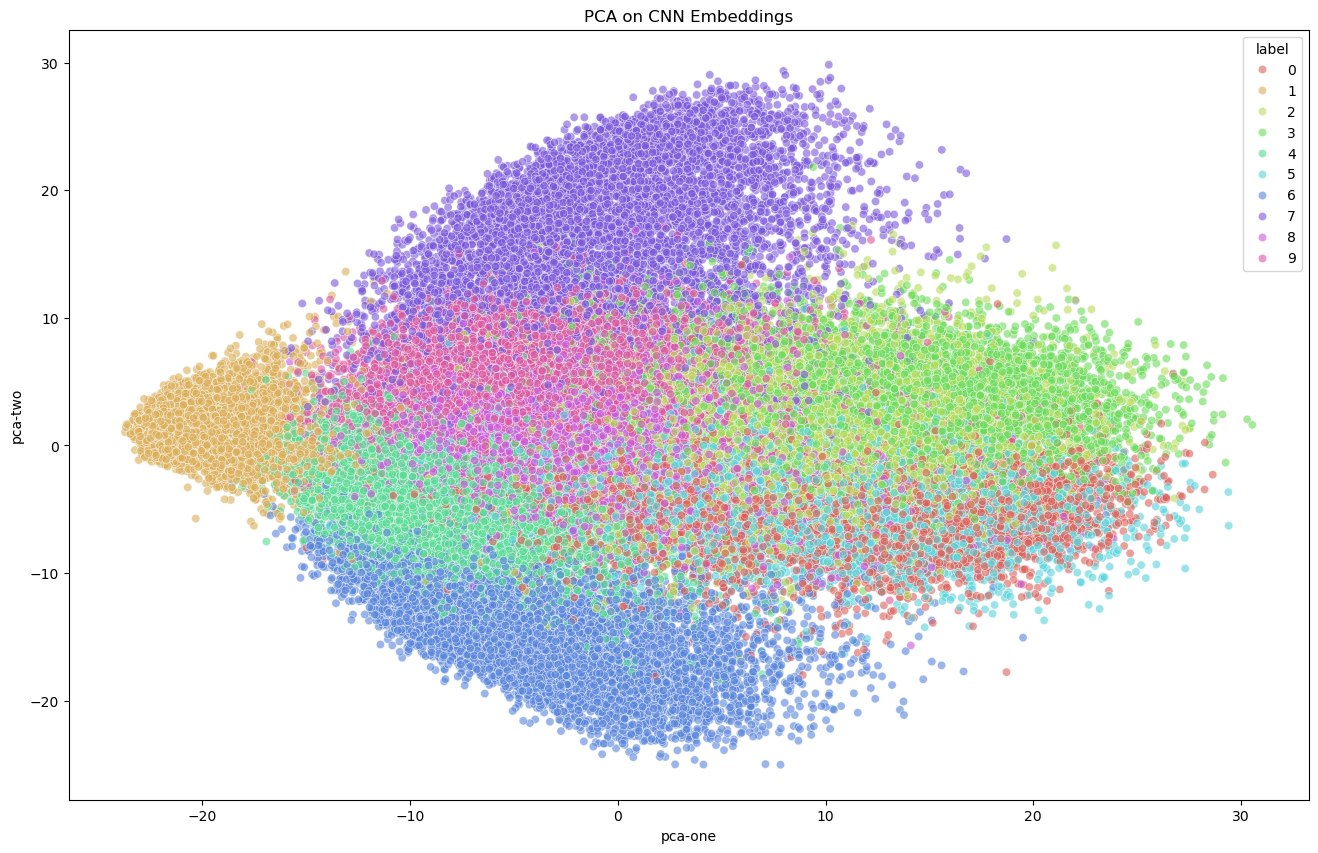

In [7]:
# Perform PCA on the embeddings
time_start = time.time()

pca = PCA(n_components=3)  # 3 components for visualization or analysis
pca_result = pca.fit_transform(embeddings_df.iloc[:, :-1].values)  # Exclude the label column
embeddings_df['pca-one'] = pca_result[:, 0]
embeddings_df['pca-two'] = pca_result[:, 1]
embeddings_df['pca-three'] = pca_result[:, 2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('PCA done! Time elapsed: {} seconds'.format(time.time() - time_start))

# Scatter plot of the first two principal components
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=embeddings_df,
    legend="full",
    alpha=0.6
)
plt.title('PCA on CNN Embeddings')
plt.show()


#### Visualizing CNN Embeddings as Images
This section demonstrates how to visualize the high-dimensional embeddings extracted from the CNN's "flat" layer by reshaping them into square-like images. The goal is to gain insight into the structure of the embeddings and how they represent the original digit data.

Embedding size 147 is not a perfect square. Visualization may distort.


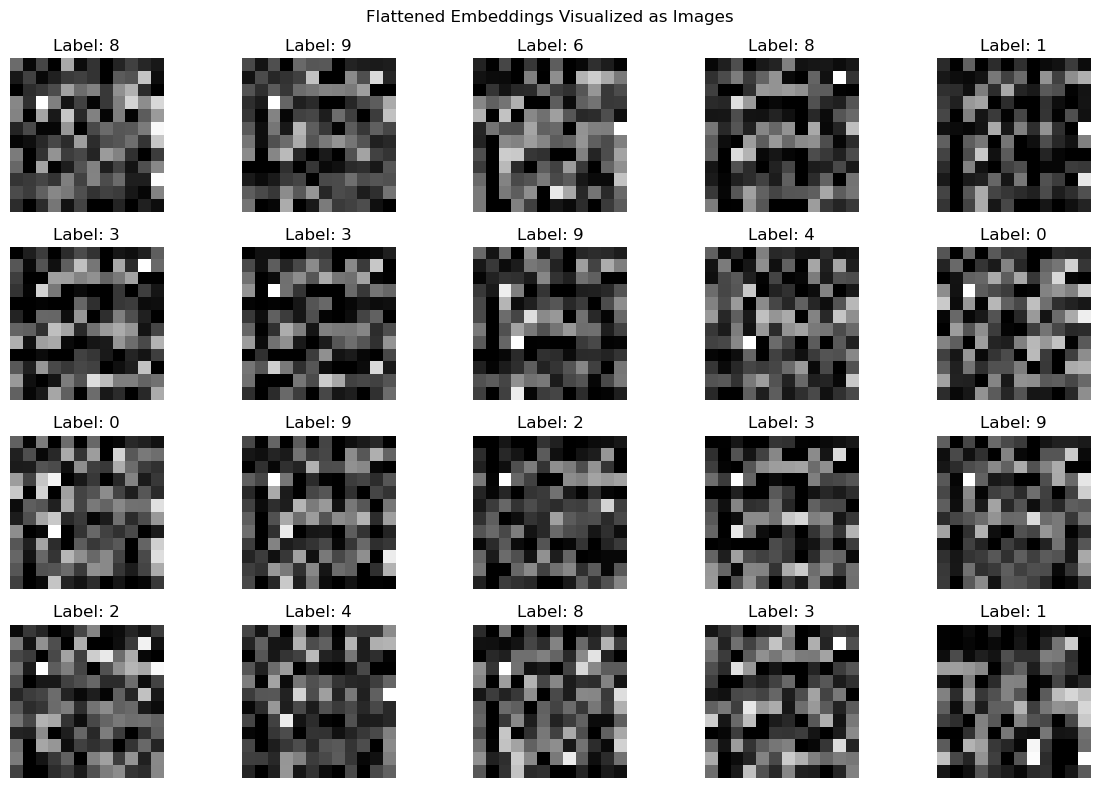

In [8]:
embeddings_images = embeddings_df.iloc[:, :-1].values  # Exclude label column
labels = embeddings_df['label'].values

# Number of embeddings to visualize
num_samples = 20

# Randomly select some samples
selected_indices = np.random.choice(embeddings_images.shape[0], num_samples, replace=False)
selected_embeddings = embeddings_images[selected_indices]
selected_labels = labels[selected_indices]

# Determine the shape for reshaping embeddings into square-like figures
embedding_length = selected_embeddings.shape[1]
image_size = int(np.sqrt(embedding_length))  # Approximate to square size
if image_size ** 2 != embedding_length:
    print(f"Embedding size {embedding_length} is not a perfect square. Visualization may distort.")

# Plot the embeddings as images
plt.figure(figsize=(12, 8))
for i, embedding in enumerate(selected_embeddings):
    plt.subplot(4, 5, i + 1)
    # Dynamically reshape into square or near-square (pad if necessary)
    reshaped_embedding = embedding[:image_size**2].reshape(image_size, image_size)
    plt.imshow(reshaped_embedding, cmap='gray')
    plt.title(f'Label: {selected_labels[i]}')
    plt.axis('off')

plt.suptitle('Flattened Embeddings Visualized as Images')
plt.tight_layout()
plt.show()


#### For a 3D-version of the above plot

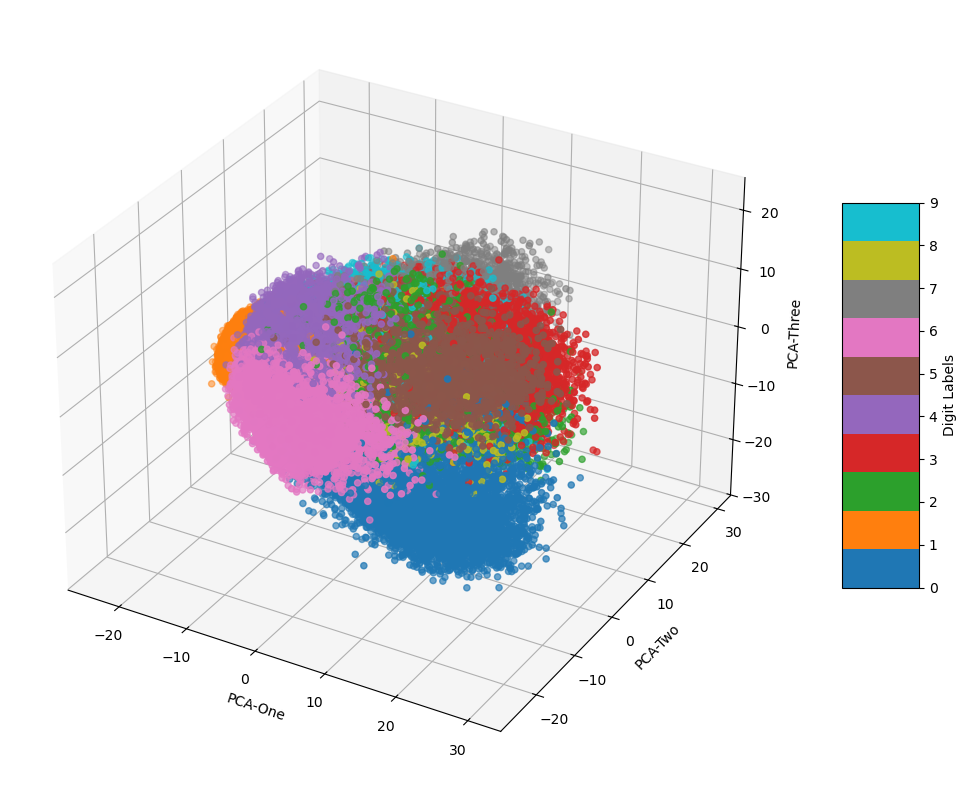

In [9]:
# Assume rndperm is a random permutation of indices
rndperm = np.random.permutation(embeddings_df.shape[0])

# Create a 3D plot
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
scatter = ax.scatter(
    xs=embeddings_df.loc[rndperm, "pca-one"],
    ys=embeddings_df.loc[rndperm, "pca-two"],
    zs=embeddings_df.loc[rndperm, "pca-three"],
    c=embeddings_df.loc[rndperm, "label"].astype(float),
    cmap='tab10'
)

# Set labels for axes
ax.set_xlabel('PCA-One')
ax.set_ylabel('PCA-Two')
ax.set_zlabel('PCA-Three')

# Add a color bar for clarity
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Digit Labels')

# Show the plot
plt.show()


### T-Distributed Stochastic Neighbor Embedding (t-SNE)
t-SNE is another technique for dimensionality reduction and is particularly well-suited for the visualization of high-dimensional datasets, such as embeddings extracted from a neural network. Contrary to PCA, it is not a mathematical technique but a probabilistic one, focusing on preserving the local structure of data in a lower-dimensional space.

It is highly recommended: in the case of very high-dimensional data (e.g., embeddings with hundreds of dimensions), you may need to apply another dimensionality reduction technique before using t-SNE. PCA is often used as a preprocessing step to reduce dimensionality while retaining most of the variance.

First, we will randomly select a subset of 15000 samples from the embeddings to run the algorithm.

In [10]:
# t-SNE setup using embeddings
# Assume embeddings_df is the DataFrame containing embeddings and labels
N = 15000  # Subset size
time_start = time.time()

# Use a subset of the embeddings
df_subset = embeddings_df.sample(n=N, random_state=42).copy()  # Random subset of embeddings
data_subset = df_subset.iloc[:, :-4].values  # Exclude PCA and label columns

# Apply PCA to reduce dimensions before t-SNE
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_subset)

# Add PCA results to the subset DataFrame
df_subset['pca-one'] = pca_result[:, 0]
df_subset['pca-two'] = pca_result[:, 1]
#df_subset['pca-three'] = pca_result[:, 2]

# Output PCA results
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('PCA on subset of data done! Time elapsed: {} seconds'.format(time.time() - time_start))


Explained variation per principal component: [0.23706006 0.14871633]
PCA on subset of data done! Time elapsed: 0.014760971069335938 seconds


#### Visualization of **PCA** on subset of data (**15000** samples)


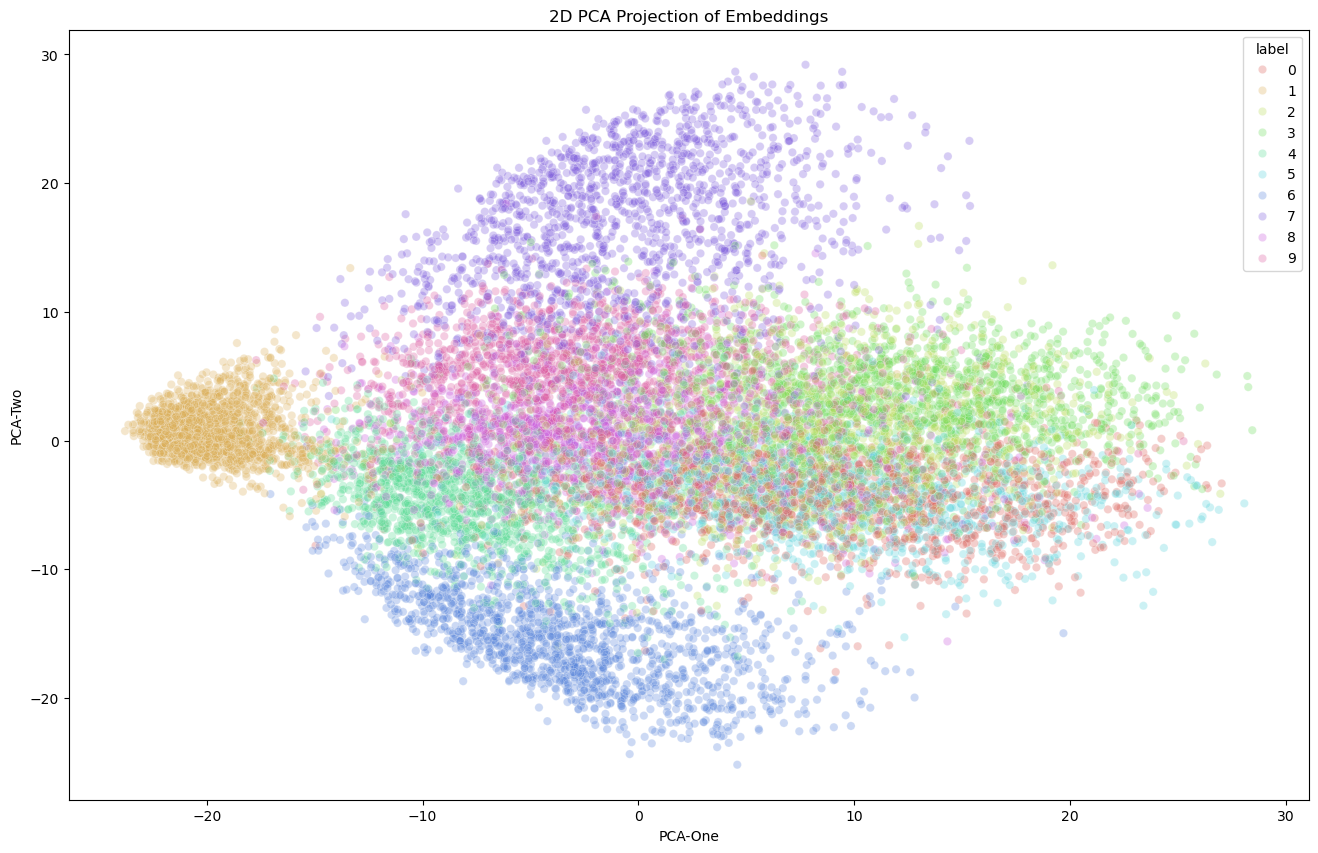

In [11]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",  # Use the label column from embeddings_df
    palette=sns.color_palette("hls", 10),  # Adjust for 10 classes (digits 0-9)
    data=df_subset,  # Use the subset with embeddings
    legend="full",
    alpha=0.3
)
plt.title('2D PCA Projection of Embeddings')
plt.xlabel('PCA-One')
plt.ylabel('PCA-Two')
plt.show()


Applying t-SNE to the Embeddings

In [12]:
from sklearn.manifold import TSNE
import time

# Applying t-SNE
time_start = time.time()

# Using t-SNE on the subset of embeddings
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(data_subset)

# Store t-SNE results in the DataFrame
df_subset['tsne-one'] = tsne_results[:, 0]
df_subset['tsne-two'] = tsne_results[:, 1]

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))


/opt/anaconda3/envs/student_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.001s...
[t-SNE] Computed neighbors for 15000 samples in 0.341s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sa

#### **T-SNE** Visualization

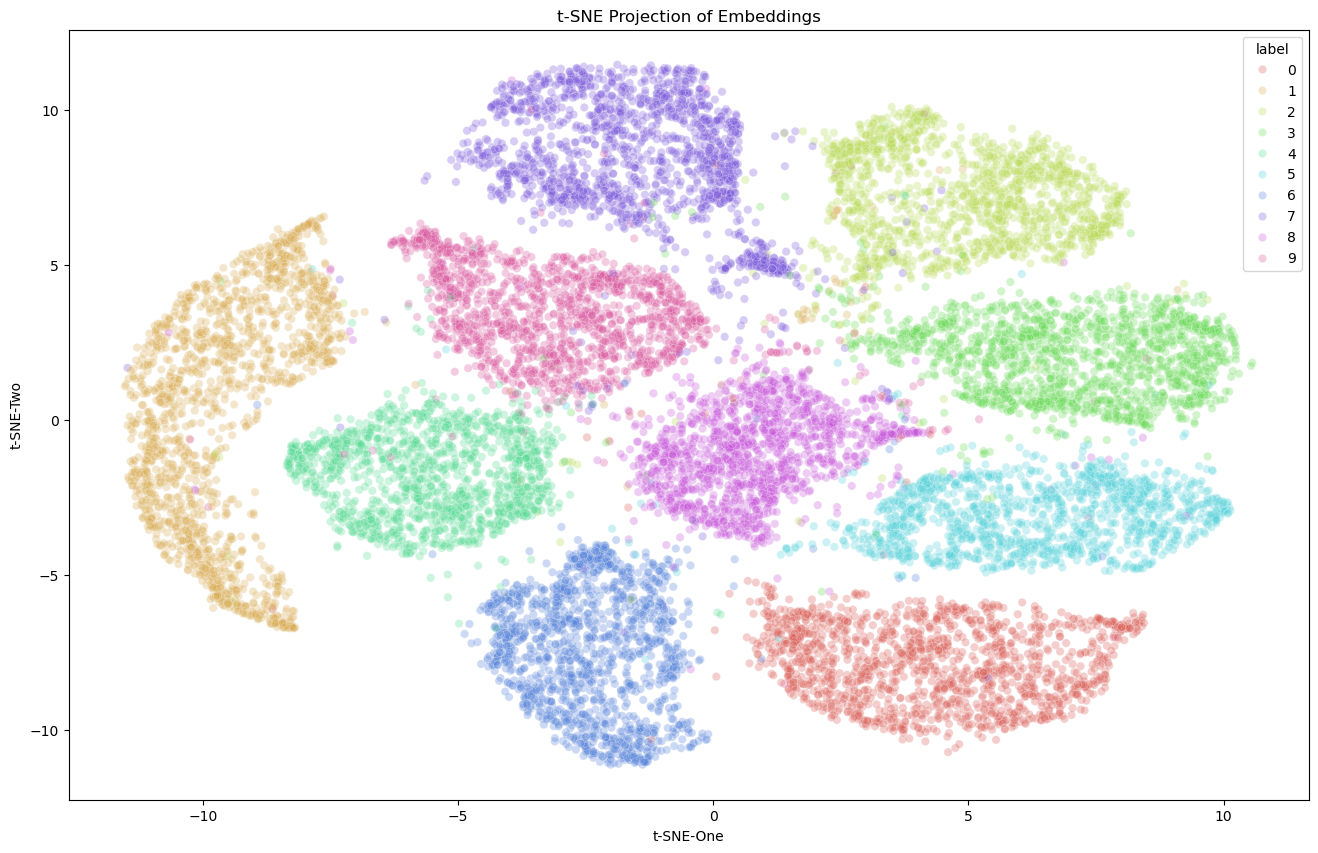

In [13]:
# Add t-SNE results to the DataFrame
df_subset['tsne-2d-one'] = tsne_results[:, 0]
df_subset['tsne-2d-two'] = tsne_results[:, 1]

# Plotting t-SNE results
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",  # Use the label column from embeddings_df
    palette=sns.color_palette("hls", 10),  # Color palette for 10 classes
    data=df_subset,
    legend="full",
    alpha=0.3
)
plt.title('t-SNE Projection of Embeddings')
plt.xlabel('t-SNE-One')
plt.ylabel('t-SNE-Two')
plt.show()


### Improvement Over the PCA Visualization

The t-SNE visualization demonstrates a significant improvement over the PCA visualization used earlier. The digits are now more distinctly clustered into their respective subgroups, showcasing the ability of t-SNE to preserve local structures and relationships within the embeddings. This highlights the effectiveness of t-SNE in revealing intricate patterns within high-dimensional data.

### Visually comparison between **PCA** and **t-SNE**

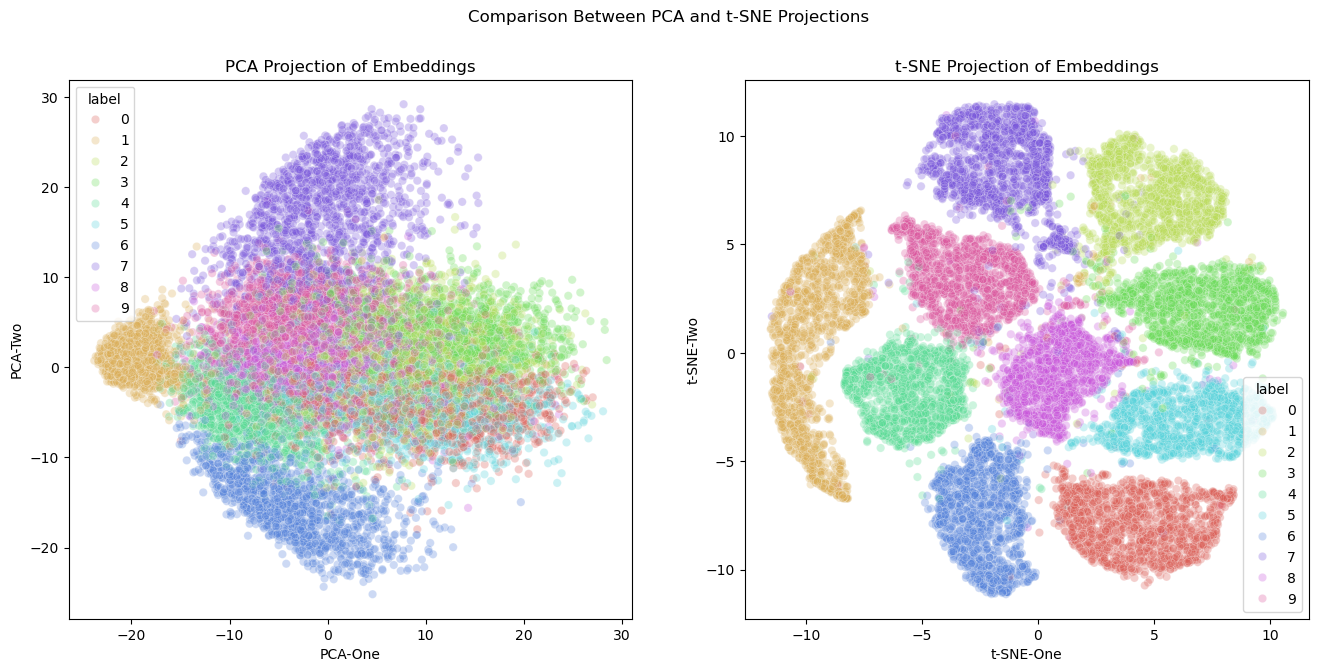

In [14]:
plt.figure(figsize=(16, 7))
plt.tight_layout()

# PCA Visualization
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",  # Use 'label' for color coding
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax1.set_title('PCA Projection of Embeddings')
ax1.set_xlabel('PCA-One')
ax1.set_ylabel('PCA-Two')

# t-SNE Visualization
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",  # Use 'label' for color coding
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax2.set_title('t-SNE Projection of Embeddings')
ax2.set_xlabel('t-SNE-One')
ax2.set_ylabel('t-SNE-Two')

plt.suptitle('Comparison Between PCA and t-SNE Projections')
plt.show()


### Dimensionality Reduction Before Feeding Data into the t-SNE Algorithm

To optimize the performance of the t-SNE algorithm and reduce computational complexity, we will first apply PCA to the data. This step creates a new dataset with reduced dimensionality, retaining the most significant 50 dimensions. We will then use this reduced dataset as input for the t-SNE algorithm to achieve better and more efficient results.

In [15]:
# Applying PCA to reduce dimensions to 50 before t-SNE
time_start = time.time()
pca_50 = PCA(n_components=50)

# Using the subset of embeddings for PCA
pca_result_50 = pca_50.fit_transform(data_subset)

# Output cumulative explained variance
print('Cumulative explained variation for 50 principal components: {:.2f}'.format(np.sum(pca_50.explained_variance_ratio_)))
print('PCA before t-SNE done! Time elapsed: {:.2f} seconds'.format(time.time() - time_start))


Cumulative explained variation for 50 principal components: 0.95
PCA before t-SNE done! Time elapsed: 0.02 seconds


### t-SNE on PCA-reduced data

In [16]:
# Apply t-SNE on the PCA-reduced data
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)

# t-SNE on the PCA-reduced dataset
tsne_pca_results = tsne.fit_transform(pca_result_50)

print('t-SNE done! Time elapsed: {:.2f} seconds'.format(time.time() - time_start))


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.002s...


/opt/anaconda3/envs/student_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 15000 samples in 0.260s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sample 13000 / 15000
[t-SNE] Computed conditional probabilities for sample 14000 / 15000

### Visualization

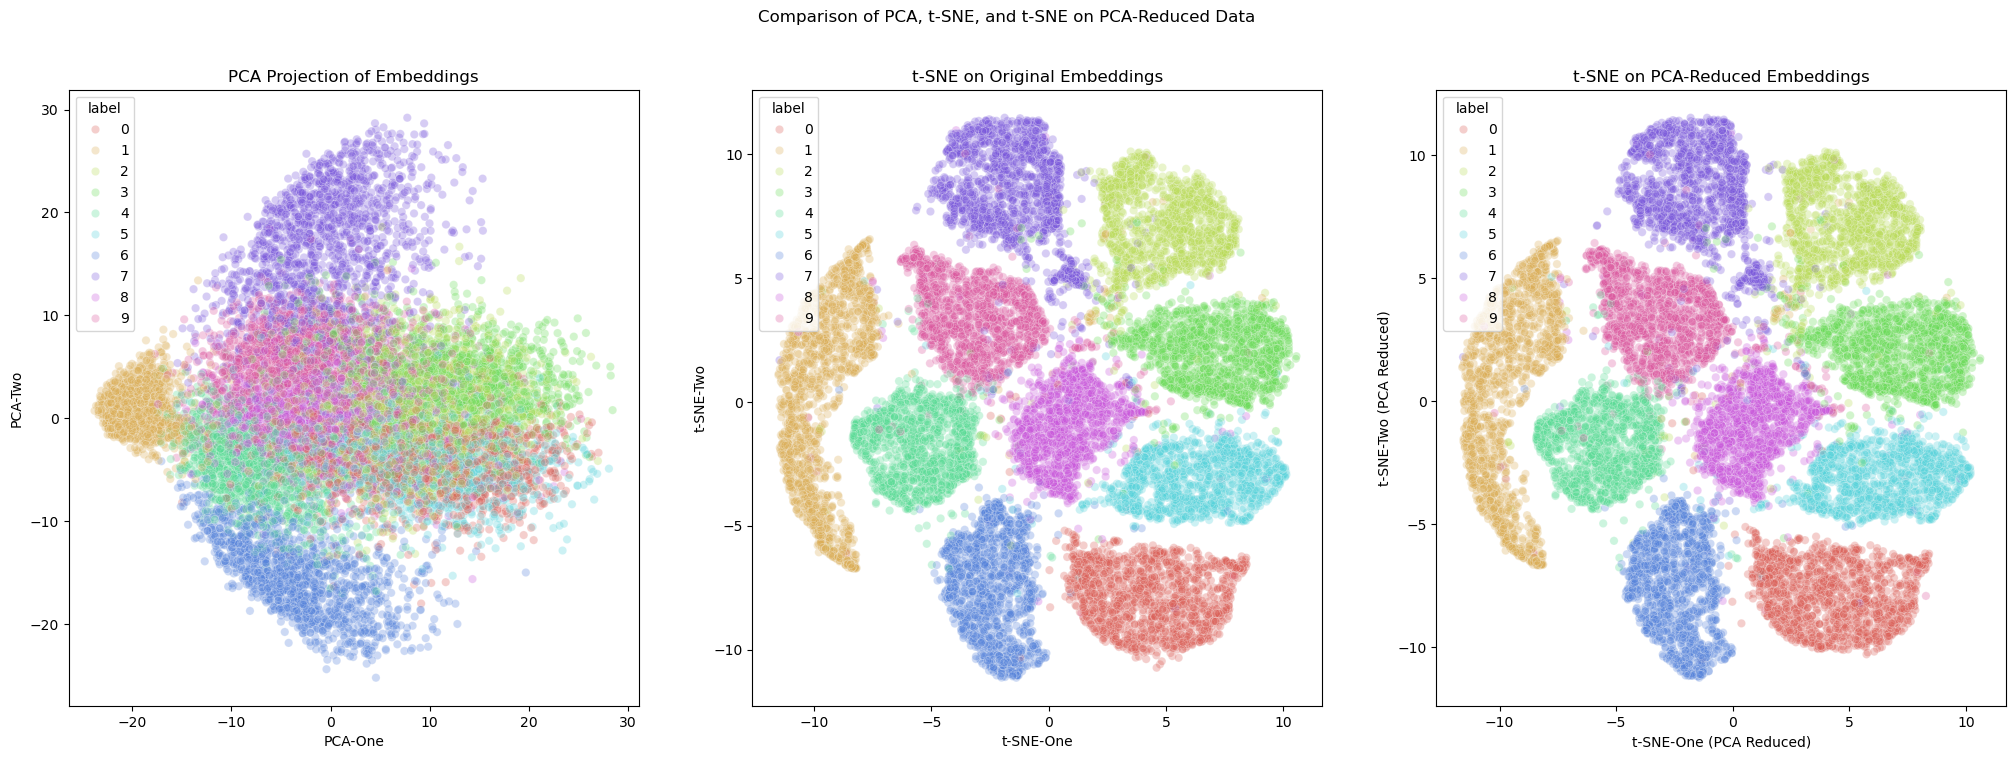

In [17]:
# Add t-SNE results on PCA-reduced data to the DataFrame
df_subset['tsne-pca50-one'] = tsne_pca_results[:, 0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:, 1]

# Plotting the visualizations
plt.figure(figsize=(25, 8))
plt.tight_layout()

# PCA Visualization
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",  # Updated to reflect correct label column
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax1.set_title('PCA Projection of Embeddings')
ax1.set_xlabel('PCA-One')
ax1.set_ylabel('PCA-Two')

# t-SNE on Original Data Visualization
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",  # Updated to reflect correct label column
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax2.set_title('t-SNE on Original Embeddings')
ax2.set_xlabel('t-SNE-One')
ax2.set_ylabel('t-SNE-Two')

# t-SNE on PCA-Reduced Data Visualization
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="label",  # Updated to reflect correct label column
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)
ax3.set_title('t-SNE on PCA-Reduced Embeddings')
ax3.set_xlabel('t-SNE-One (PCA Reduced)')
ax3.set_ylabel('t-SNE-Two (PCA Reduced)')

plt.suptitle('Comparison of PCA, t-SNE, and t-SNE on PCA-Reduced Data')
plt.show()
